In [7]:
!pip install metpy
!pip install geopandas

     |████████████████████████████████| 972kB 13.1MB/s 
     |████████████████████████████████| 6.5MB 15.4MB/s 
     |████████████████████████████████| 14.8MB 314kB/s 


In [8]:
import pandas as pd
import metpy
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

In [3]:
stations_inventory = pd.read_csv('https://www1.ncdc.noaa.gov/pub/data/noaa/isd-inventory.csv',dtype='str')
stations_list = pd.read_csv('https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv',dtype='str')
stations_list.head(2)

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,+00.000,+000.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,+00.000,+000.000,+7026.0,20120713,20170822


In [26]:
ds = pd.DataFrame()
ds['station'] = stations_list['STATION NAME']
ds['begin'] = pd.to_datetime(stations_list['BEGIN'], format='%Y%m%d')
ds['end'] = pd.to_datetime(stations_list['END'], format='%Y%m%d')
ds['latitude'] = stations_list['LAT']
ds['longitude'] = stations_list['LON']

start = pd.Timestamp(1976,1,1)
end = pd.Timestamp(2005,12,31)


ds = ds[ds['begin'] < start]
ds = ds[ds['end'] > end]

# convert ds to a geodataframe and create list of points
# then use the following


gdf = gpd.GeoDataFrame(
    ds, geometry=gpd.points_from_xy(ds.longitude, ds.latitude))

# the Point() coordinates need to be translated from the WGS84 to cartesian system
pt_a = Point(49.264703,-123.148943)
ls = LineString([Point(point.x, point.y) for point in gdf.geometry])
nearest_pts = [pt for pt in nearest_points(pt_a, ls)]

print('From ',nearest_pts[0].x,' to ',nearest_pts[1].x)
print('From ',nearest_pts[0].y,' to ',nearest_pts[1].y)

From  49.264703  to  44.27122334587769
From  -123.148943  to  -84.29351324298318


In [ ]:
stations_list[stations_list['STATION NAME'].str.contains('PORTLAND', na=False)]

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
1753,038550,99999,PORTLAND BILL C.G.,UK,NaN,NaN,+50.517,-002.433,+0053.0,19730112,20021101
1754,038560,99999,PORTLAND BILL (LH),UK,NaN,NaN,+50.517,-002.450,+0011.0,19291001,20041129
1755,038570,99999,ISLE OF PORTLAND,UK,NaN,NaN,+50.517,-002.450,+0052.0,19730809,20201014
1756,038580,99999,PORTLAND HELIPORT,UK,NaN,EGDP,+50.567,-002.450,+0003.0,19730108,20021220
20510,726060,14764,PORTLAND INTERNATIONAL JETPORT AP,US,ME,KPWM,+43.642,-070.304,+0013.7,19730101,20201015
20537,726087,99999,PORTLAND HEAD COAST GUARD LIGHT,US,NaN,NaN,+43.620,-070.200,+0023.0,19780211,19890523
21023,726980,24229,PORTLAND INTERNATIONAL AIRPORT,US,OR,KPDX,+45.596,-122.609,+0005.8,19360501,20201015
21024,726985,24242,PORTLAND-TROUTDALE AIRPORT,US,OR,KTTD,+45.551,-122.409,+0008.8,20060101,20201015
21025,726985,99999,PORTLAND TROUTDALE,US,OR,KTTD,+45.550,-122.400,+0012.0,19480101,20051231
21026,726986,94261,PORTLAND-HILLSBORO AIRPORT,US,OR,KHIO,+45.541,-122.949,+0062.2,20060101,20201015


In [ ]:
df = pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/1999/72698599999.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,20,21,22,26,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,AA1,AA2,AA3,AG1,AJ1,GA1,GA2,GD1,GD2,GD3,GD4,GF1,GP1,GQ1,GR1,KA1,KA2,MA1,MD1,MW1,MW2,MW3,MW4,OC1,REM,EQD
0,72698599999,1999-01-01T00:00:00,9,45.55,-122.4,12.0,"PORTLAND TROUTDALE, OR US",NSRDB,99999,V020,"999,9,9,9999,9","99999,9,9,9","999999,9,9,9","+9999,9","+9999,9","99999,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0060,0135,02,008,0379,02,015,0081,02,008","0060,0819,9,2248,9","0060,0200,9,1415,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72698599999,1999-01-01T00:53:00,4,45.55,-122.4,12.0,"PORTLAND TROUTDALE, OR US",FM-15,KTTD,V020,"280,1,N,0021,1","01800,1,9,N","016093,1,N,1","+0080,1","+0030,1","10255,1","01,0000,2,1",NaN,NaN,"1,999",NaN,NaN,NaN,"4,99,1,+01800,1,9",NaN,NaN,NaN,"08,99,1,99,9,99,9,99999,9,99,9,99,9",NaN,NaN,NaN,NaN,NaN,"10257,1,99999,9",NaN,"00,1",NaN,NaN,NaN,NaN,MET037NEW AO2 RAE13 SLP255 P0000 T00830033;,Q01+000000PRSWM2
2,72698599999,1999-01-01T01:00:00,9,45.55,-122.4,12.0,"PORTLAND TROUTDALE, OR US",NSRDB,99999,V020,"999,9,9,9999,9","99999,9,9,9","999999,9,9,9","+9999,9","+9999,9","99999,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0060,0002,02,008,0085,02,015,0001,02,008","0060,0878,9,2336,9","0060,0030,9,0790,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72698599999,1999-01-01T01:53:00,4,45.55,-122.4,12.0,"PORTLAND TROUTDALE, OR US",FM-15,KTTD,V020,"270,1,N,0015,1","22000,1,9,N","016093,1,N,1","+0070,1","+0030,1","10262,1",NaN,NaN,NaN,"1,999",NaN,NaN,NaN,"2,99,1,+01800,1,9",NaN,NaN,NaN,"04,99,1,99,9,99,9,99999,9,99,9,99,9",NaN,NaN,NaN,NaN,NaN,"10264,1,99999,9",NaN,"00,1",NaN,NaN,NaN,NaN,MET025NEW AO2 SLP262 T00670028;,Q01+000000PRSWM2
4,72698599999,1999-01-01T02:00:00,9,45.55,-122.4,12.0,"PORTLAND TROUTDALE, OR US",NSRDB,99999,V020,"999,9,9,9999,9","99999,9,9,9","999999,9,9,9","+9999,9","+9999,9","99999,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0060,0000,02,000,0000,02,000,0000,02,000",NaN,"0060,0000,9,0000,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wind = df.WND.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'wind_dir',
                                                                            1:'wind_dirqc',
                                                                            2:'wind_type',
                                                                            3:'wind_spd',
                                                                            4:'wind_spdqc'})

sky = df.CIG.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'sky_clg',
                                                                               1:'sky_clgqc',
                                                                               2:'sky_clgmethod',
                                                                               3:'sky_cavok'})

vis = df.VIS.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'vis_dist',
                                                                               1:'vis_distqc',
                                                                               2:'vis_variable',
                                                                               3:'vis_variableqc'})

temp = df.TMP.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'temp_cels',
                                                                               1:'temp_cels_qc'})

dew = df.DEW.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'dew_temp',
                                                                               1:'dew_tempqc'})

psl = df.SLP.str.split(pat=',',expand=True).set_index(df.DATE).rename(columns={0:'psl_hpscal',
                                                                               1:'psl_hpscalqc'})


# datetime.strptime(d, "%Y-%m-%dT%H:%M:%S%z"
dfall = pd.concat([wind,sky,vis,temp,dew,psl],axis=1)
dfall = dfall.replace(['999','9','9999','99999','999999'],np.nan)
dfall.index = pd.to_datetime(dfall.index)#, "%Y-%m-%dT%H:%M:%S")
del dfall['wind_type']
del dfall['sky_clgmethod']
del dfall['sky_cavok']
del dfall['vis_variable']

def check(x):
  if '+' in x:
    x.replace('+','')
    x = float(x)/10
  elif '-' in x:
    x.replace('-','')
    x = float(x)*-1
    x = x/10
  else:
    x = x/10
  if x>100 or x<-100:
    x = np.nan
  else:
    x=x
  return x

dfall['temp_cels'] = dfall.apply(lambda x: check(x['temp_cels']), axis=1)
dfall['dew_temp'] = dfall.apply(lambda x: check(x['dew_temp']), axis=1)

dfall = dfall.fillna(method='bfill').fillna(method='ffill').astype(float)
dfall['wind_spd'] = dfall['wind_spd']/10
dfall['psl_hpscal'] = dfall['psl_hpscal']/10
dfobs = dfall[['wind_dir','wind_spd','sky_clg',
               'temp_cels','dew_temp','psl_hpscal']].resample('1H').mean()
def rhcalc(temp,dew): #magnus approximation
  return 100*(np.exp((17.625*dew)/(243.04+dew))/np.exp((17.625*temp)/(243.04+temp)))

dfobs['hurs'] = dfobs.apply(lambda x: rhcalc(x['temp_cels'],x['dew_temp']),axis=1)
dfobs = dfobs.round(1)
dfobs.head()

,wind_dir,wind_spd,sky_clg,temp_cels,dew_temp,psl_hpscal,hurs
DATE,,,,,,,
1999-01-01 00:00:00,280.0,2.1,1800.0,8.0,3.0,1025.5,70.7
1999-01-01 01:00:00,270.0,1.5,22000.0,7.0,3.0,1026.2,75.7
1999-01-01 02:00:00,230.0,1.5,1800.0,6.0,4.0,1026.8,87.0
1999-01-01 03:00:00,260.0,1.5,1440.0,6.0,3.0,1027.2,81.1
1999-01-01 04:00:00,240.0,1.5,1260.0,6.0,3.0,1027.8,81.1


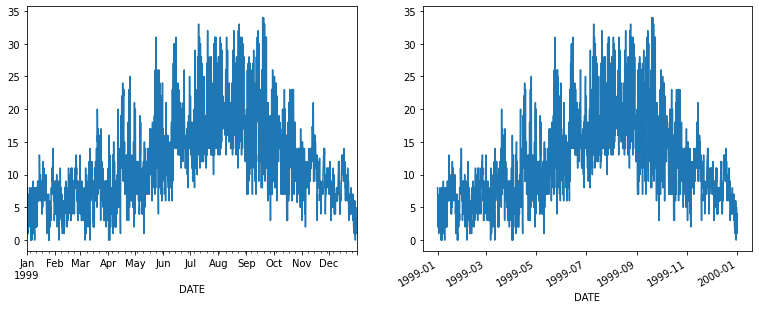

In [ ]:
fig, axs = plt.subplots(1,2,figsize=[13,5])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
dfall.resample('1H').mean()['temp_cels'].plot(ax=axs[0])
dfall['temp_cels'].plot(ax=axs[1])

In [ ]:
temp = 8
dew = 4

def rhcalc(temp,dew):
  return 100*(np.exp((17.625*dew)/(243.04+dew))/np.exp((17.625*temp)/(243.04+temp)))
  
rhcalc(8,4)

75.85970079465399

In [ ]:
import metpy.calc as mpcalc
from metpy.units import units
temp = 8 * units('degC')
dew = 3 * units('degC')


mpcalc.relative_humidity_from_dewpoint(temp,dew)

0.7067933943079973 dimensionless